WORK IN PROGRESS.

In [1]:
import hist
import numpy as np
import matplotlib.pyplot as plt

# Classic histograms in 1D

Let's start with the basics. We will create a histogram the classic way, using a simple, random dataset.

## Simple introduction

Let's make a 1d dataset to run on.

In [2]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000)

This is a random, gaussian dataset. If you wanted to visualize it, you would probably would _NOT_ do this (plotting the first 1,000 points just to keep SVG/PDF backends from bogging down):


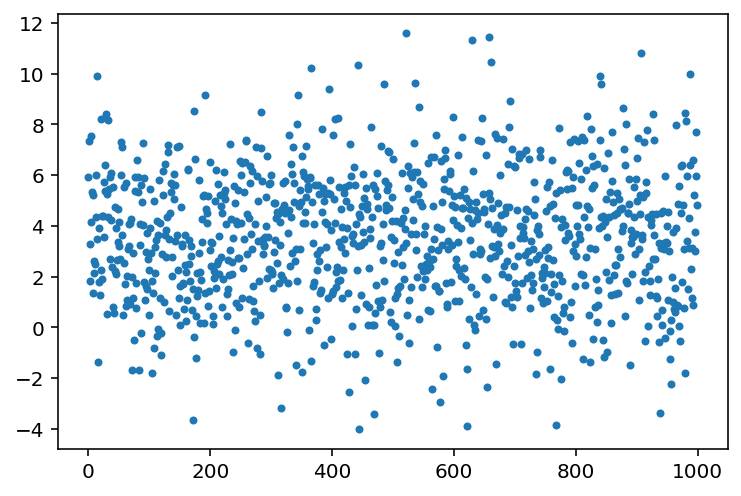

In [3]:
plt.plot(data1[:1000], '.');

Instead, you would look at a histogram like this:

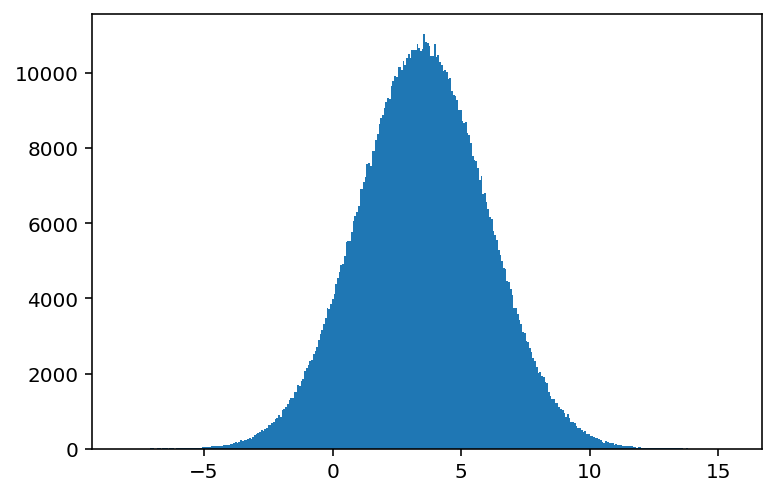

In [4]:
plt.hist(data1, bins='auto');

This is _one_ of the uses of a histogram, often the one you are most familar with; it's a vizualization tool. But it's much, much more too.

If you wanted to actually convert this yourself, you can use NumPy's built in function:

In [5]:
np.histogram(data1, range=(-5, 10), bins=10)

(array([  2171,  11101,  40659, 103966, 186706, 234898, 208173, 131546,
         57856,  17990]),
 array([-5. , -3.5, -2. , -0.5,  1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. ]))

The return value here is two NumPy arrays, one with bin contents (frequencies), and the other with bin edges.

We can smoothy transition to using the hist library by using the `hist.numpy` adaptor.

In [6]:
hist.numpy.histogram(data1, range=(-5, 10), bins=10)

(array([  2171,  11101,  40659, 103966, 186706, 234898, 208173, 131546,
         57856,  17990], dtype=uint64),
 array([-5. , -3.5, -2. , -0.5,  1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. ]))

Is there a reason we might want to do this (other than to get to the remainder of the lesson)? Let's check performance:

In [7]:
%%timeit
_,_ = np.histogram(data1, bins=100)

31.2 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
_,_ = hist.numpy.histogram(data1, bins=100)

12.7 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Hist is backed by the boost-histogram library, providing compiled performance based on the C++ Boost.Histogram. We'll see even more impressive speedups later.

## The histogram object

Now, let's see what a Histogram object looks like.

In [9]:
h = hist.numpy.histogram(data1, bins=100, histogram=hist.Hist)
h

Hist(Regular(100, -8.17061, 15.5039, label='Axis 0'), storage=Int64()) # Sum: 1000000.0

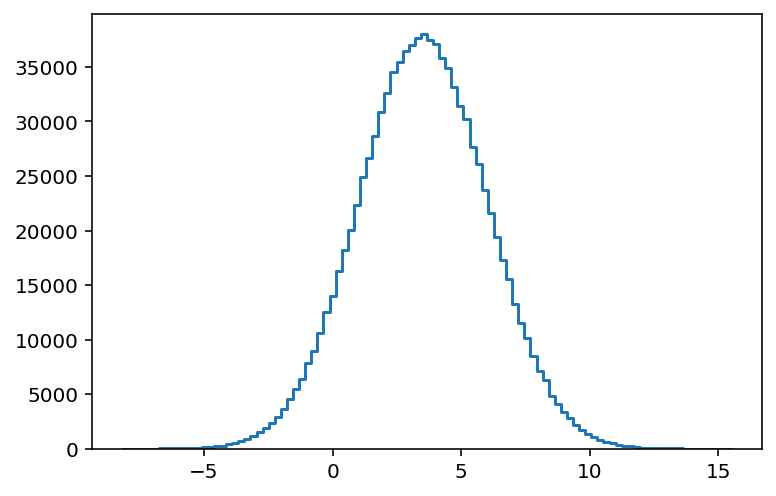

In [10]:
h.plot();

This is now an _object_, rather than a tuple of NumPy arrays.

You could make it yourself without the adaptor:

In [11]:
h = hist.Hist(hist.axis.Regular(300, -5, 10, name="x"))
h.fill(data1)

Hist(Regular(300, -5, 10, name='x', label='x'), storage=Double()) # Sum: 995066.0 (1000000.0 with flow)

There is something to notice here; the fill method mutates the histogram object (it does return itself, so you can chain this functional style if you want). This means that you can fill the histogram multiple times, it's not one-and-done like NumPy!

You can slice it:

In [12]:
h[20:40]

Hist(Regular(20, -4, -3, name='x', label='x'), storage=Double()) # Sum: 3176.0 (1000000.0 with flow)

Notice how the bin information is propogated with the histogram.


If you want to slice in data coordinates, just add a "j" suffix:

In [13]:
h[-2j:2j]

Hist(Regular(80, -2, 2, name='x', label='x'), storage=Double()) # Sum: 260421.0 (1000000.0 with flow)

You can even mix location and bin number access. You can also rebin by placing a `j` suffixed number in the final slice slot, which we call the "action". This looks quite a bit like a step, but instead of every Nth bins, you are merging N adjacent bins.

In [14]:
h[::10j]

Hist(Regular(30, -5, 10, name='x', label='x'), storage=Double()) # Sum: 995066.0 (1000000.0 with flow)

Let's look at some information about the histogram. First, how about the sum?

In [15]:
h.sum()

995066.0

That's not the total number of entries we put in. Why not?

---

Answer: they were outside the range of the Axis. Some of them were too large, some were too low. There are special (and optional) bins for these two cases, called the underflow and the overflow. We can include them in the sum:

In [16]:
h.sum(flow=True)

1000000.0

Later these will enable some powerful things like lossless projections. Most of the time, you can ignore they are there.

Let's plot this by hand instead of calling `.plot()`:

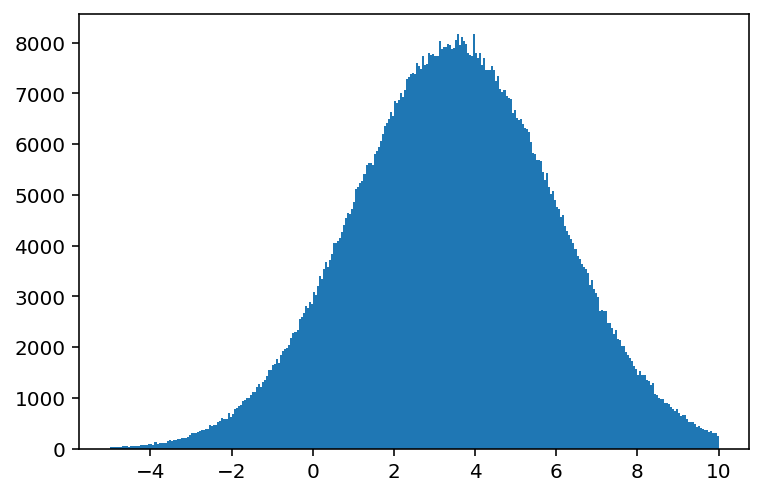

In [17]:
plt.bar(h.axes[0].centers, h.view(), width=h.axes[0].widths);

Note: You can leave off the `.view()` if you want to - histograms conform to the Python buffer protocol. There will be a lot more on this later.
You can begin to see how, while we are currently discussing 1D histograms, ND histograms have exactly the same interface, just with more axes.

Aside: here's step. It's quite ugly for us out of the box in matplotlib, just like it is for numpy. In Matplotlib 3.4, we have added a `plt.stairs` function which makes plotting beautiful pre-binned histograms much simpler.

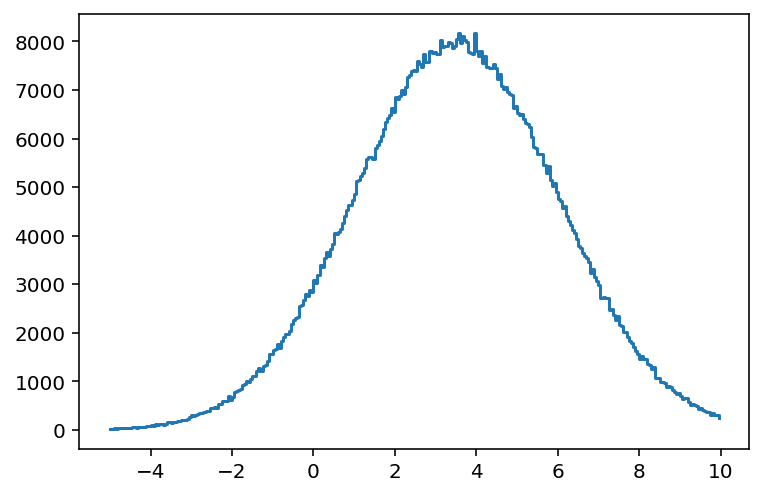

In [18]:
plt.step(h.axes[0].edges[:-1], h, where='post');

Thsi is not _quite_ right, the edges are inconsistent (as you might gather from having to leave one edge off above) but `plt.stairs` fixes this; polishing it off manualy is quite a bit of effort.


## Properties

There are some fantastic properties of Histograms that make analysis simple and easy. Let's look at axis breifly, using a rebinned histogram to keep the display short and sweet:

In [19]:
hs = h[::30j]

In [20]:
hs.axes[0].centers

array([-4.25, -2.75, -1.25,  0.25,  1.75,  3.25,  4.75,  6.25,  7.75,
        9.25])

In [21]:
hs.axes[0].edges

array([-5. , -3.5, -2. , -0.5,  1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. ])

In [22]:
hs.axes[0].widths

array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])

In [23]:
hs.axes[0].name

'x'

## Making a density histogram

Let's try to make a density histogram like Numpy's.

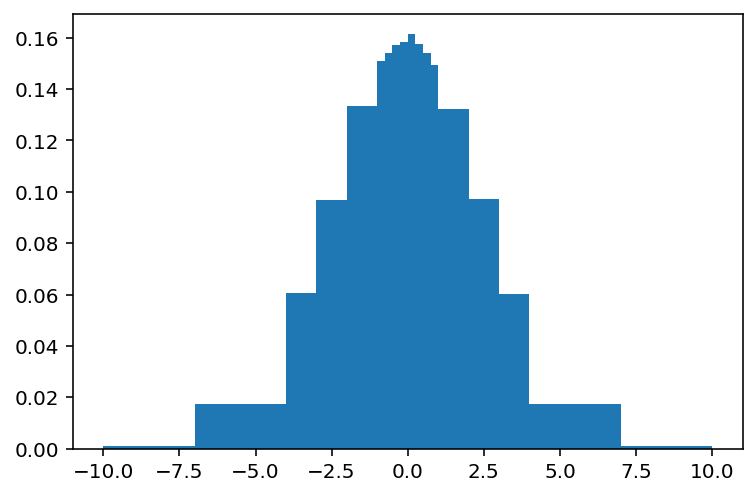

In [24]:
bins = [-10, -7, -4, -3, -2, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 2, 3, 4, 7, 10]
d7, e7 = np.histogram(data1 - 3.5, bins=bins, density=True)
plt.hist(data1 - 3.5, bins=bins, density=True);

Yes, it's ugly. Don't judge.

Yes, I'm aware there's a `.density()` method. That's not fun, let's try making out of basic building blocks.

In [25]:
hd = hist.Hist(hist.axis.Variable(bins))
hd.fill(data1 - 3.5)

widths = hd.axes.widths
area = np.prod(widths, axis=0)

area

array([3.  , 3.  , 1.  , 1.  , 1.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 1.  , 1.  , 1.  , 3.  , 3.  ])

Yes, that does not need to be so complicated for 1D, but it's general.

In [26]:
factor = np.sum(hd.view())
density = hd.view() / (factor * area)

TODO: replace with .values() after boost-histogram 0.13/1.0 release.

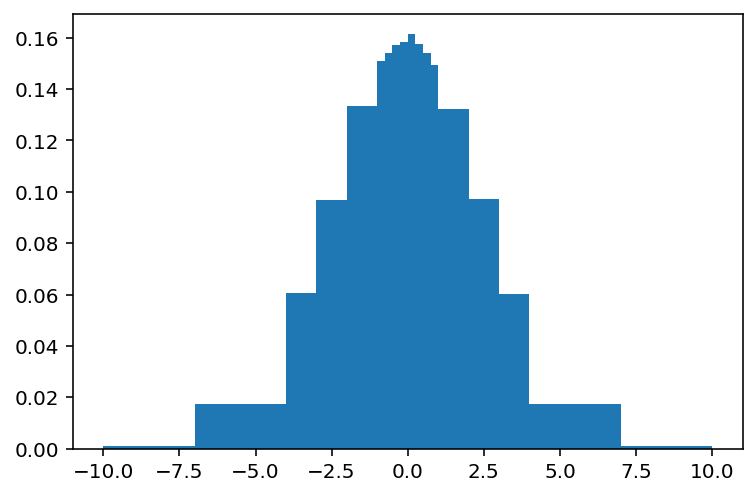

In [27]:
plt.bar(hd.axes[0].centers, density, width=hd.axes[0].widths);

Let's break up and try worksheet one!